In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from scipy.stats import norm
from utils.print_utils import *
from utils.model_utils import *
from utils.interpol_utils import *
from utils.optimization_utils import *
from utils.data_utils import *
from utils.filters_utils import *
from utils.rbf import *

In [3]:
data = load_data('../data/AAPL250117C00150000.csv')

data['Expiration Date'] = pd.to_datetime(data['Expiration Date'])
data['Date'] = pd.to_datetime(data['Date'])

data['tal'] = (data['Expiration Date'] - data['Date']).dt.days/365

In [4]:
data

,Symbol,Underlying,Expiration Date,Option Side,Strike,First Traded,Days To Expiration,Date,Bid,Bid Size,...,Ask,Ask Size,Last,Open Interest,Volume,In The Money,Intrinsic Value,Extrinsic Value,Underlying Price,tal
0,AAPL250117C00150000,AAPL,2025-01-17,call,150,9/10/2022,501,2022-09-12,43.00,1,...,44.30,17,43.70,0,65,True,13.43,30.22,163.43,2.350685
1,AAPL250117C00150000,AAPL,2025-01-17,call,150,9/10/2022,501,2022-09-13,37.00,30,...,39.30,5,37.55,52,82,True,3.84,34.31,153.84,2.347945
2,AAPL250117C00150000,AAPL,2025-01-17,call,150,9/10/2022,501,2022-09-14,36.75,41,...,39.80,63,37.99,90,56,True,5.31,32.97,155.31,2.345205
3,AAPL250117C00150000,AAPL,2025-01-17,call,150,9/10/2022,501,2022-09-15,36.65,1,...,37.30,53,36.80,111,71,True,2.37,34.61,152.37,2.342466
4,AAPL250117C00150000,AAPL,2025-01-17,call,150,9/10/2022,501,2022-09-16,35.35,30,...,37.75,30,35.96,147,394,True,0.70,35.85,150.70,2.339726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,AAPL250117C00150000,AAPL,2025-01-17,call,150,9/10/2022,501,2023-01-25,23.30,96,...,23.90,3,23.55,6801,1090,False,0.00,23.60,141.86,1.980822
95,AAPL250117C00150000,AAPL,2025-01-17,call,150,9/10/2022,501,2023-01-26,23.90,60,...,25.10,32,24.65,7458,35,False,0.00,24.50,143.96,1.978082
96,AAPL250117C00150000,AAPL,2025-01-17,call,150,9/10/2022,501,2023-01-27,24.90,258,...,26.00,4,26.13,7467,209,False,0.00,25.45,145.93,1.975342
97,AAPL250117C00150000,AAPL,2025-01-17,call,150,9/10/2022,501,2023-01-30,23.65,161,...,24.35,244,23.95,7394,19,False,0.00,24.00,143.00,1.967123


In [5]:
u = data['Extrinsic Value'].values
x = data['Underlying Price'].values
t = data['tal'].values
K_ = data['Strike'][0]

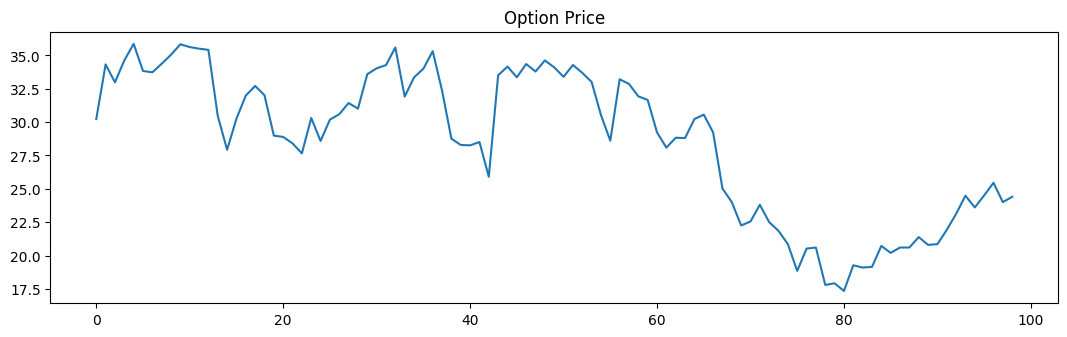

In [8]:
u_t = ps.SmoothedFiniteDifference()._differentiate(u,t = t)
u_t_ = ps.FiniteDifference(order = 4)._differentiate(u,t = t)

plt.figure(figsize=(13, 12))
plt.subplot(3,1,1)

plt.title('Option Price')
plt.plot(u)

# plt.subplot(3,1,3)

# plt.title('Option time finite derivative ')
# plt.plot(u_t_)

# plt.subplot(3,1,2)

# plt.title('Option time smoothed derivative ')
# plt.plot(u_t)


In [7]:
X, T = np.meshgrid(x,t)

# Perform RBF interpolation on the original grid
rbf_call_prices = rbf_interpolation_on_grid(x, t, u, X, T)
# rbf_call_prices = gaussian_filter(rbf_call_prices,sSS=igma=1)
# Compute the numerical derivatives of the RBF interpolated surface
# First derivatives
rbf_deltas_numerical = numerical_derivative(rbf_call_prices, axis=0, h=h_S)
rbf_theta_numerical = numerical_derivative(rbf_call_prices, axis=1, h=h_T)

# Second derivatives
rbf_gamma_numerical = numerical_second_derivative(rbf_call_prices, axis=0, h=h_S)


NameError: name 'h_S' is not defined

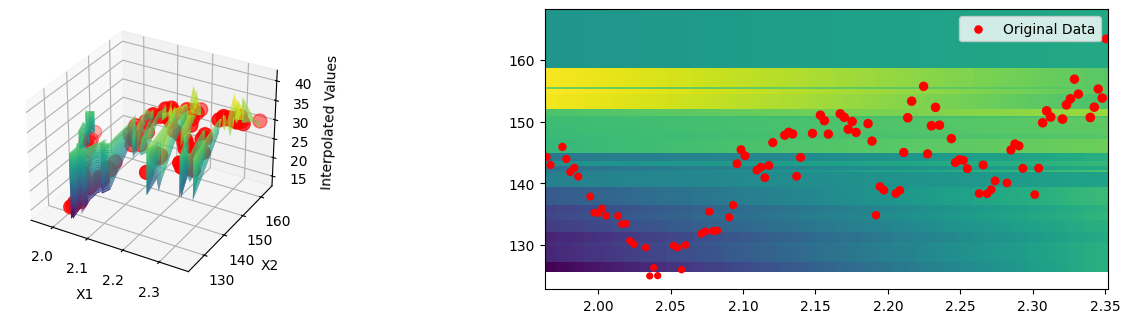

In [ ]:
smoothed_Z = moving_average_2d(rbf_call_prices.reshape(X.shape),kernel_size=5)

# Plot the interpolated surface
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(t, x, rbf_call_prices.reshape(X.shape), cmap='viridis')

# Plot the original data points
ax.scatter(t, x, u, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')

ax2 = fig.add_subplot(222)
ax2.pcolormesh(t, x, rbf_call_prices.reshape(X.shape).T)
ax2.scatter(t, x, u, c='red', label='Original Data')
ax2 = plt.gca()

plt.legend()
plt.show()

In [ ]:
numerical_derivative_interpolated = ps.FiniteDifference(axis=0,order = 2)._differentiate(interpolated_values,t = np.ravel(x1_grid))

smoothed_Zy = moving_average_2d(numerical_derivative_interpolated.reshape((100,100)), kernel_size=5)  # sigma controls the degree of smoothing


numerical_2nd_derivative_interpolated = ps.SmoothedFiniteDifference(axis=0,order = 2)._differentiate(interpolated_values,t = np.ravel(x1_grid))
smoothed_Zyy = moving_average_2d(numerical_2nd_derivative_interpolated.reshape((100,100)), kernel_size=5)  # sigma controls the degree of smoothing


In [ ]:
_,_, _,interpolated_values_t,_,_ = RBFN_2d(X,u,K_,cubic_rbf())
Smoothed_Zt = moving_average_2d(interpolated_values_t.reshape(x1_grid.shape),kernel_size=10)


In [ ]:
Theta = np.array([np.ravel(x1_grid),np.ravel(x1_grid)**2,interpolated_values,np.ravel(smoothed_Zy.T),np.ravel(smoothed_Zyy.T)]).T

In [ ]:
Crossed_Theta,Theta_names = build_cross_library(Theta,['x','x^2','u','u_x','u_xx'])

In [ ]:
optimizer = ps.STLSQ(threshold=1e-5, alpha=1e3).fit(Crossed_Theta[:],interpolated_values_t.ravel())

print_model(optimizer.coef_[0],Theta_names,precision=5)

u_t = + -0.26337 x + 0.00436 x^2 + -0.06859 u + -0.00056 u_x + 0.0027 u_xx + -2e-05 x*x^2 + -0.00174 x*u + 0.00701 x*u_x + -0.00141 x*u_xx + 2e-05 x^2*u + -4e-05 x^2*u_x + -0.00557 u*u_x + 0.00555 u*u_xx + -0.0977 u_x*u_xx


In [ ]:
new_coef = threshold_remove(Crossed_Theta,optimizer.coef_[0],Smoothed_Zt.ravel(),threshold=0.1,axis=1)
print_model(new_coef,Theta_names,precision=5)

u_t = + -0.0935 x + 0.0015 x^2 + -2.01302 u + -1e-05 x*x^2 + 0.02757 x*u + 0.00703 x*u_x + 0.00022 x*u_xx + -9e-05 x^2*u + -3e-05 x^2*u_x + -0.01198 u*u_x
